# Network Traffic Anomaly Detection – Model Testing

In this notebook, we evaluate the performance of previously trained machine learning models on unseen network traffic data from the CICIDS2017 dataset.

The main objectives of this notebook are:

- Load and preprocess new testing data using the pipeline from `preprocess.py`
- Reuse trained classifiers from the model training phase (e.g., Random Forest, Decision Tree, XGBoost)
- Assess generalization by evaluating models on new attack types or scenarios
- Measure performance using:
  - Confusion Matrix
  - Precision, Recall, and F1-Score
  - ROC-AUC score
- Analyze how well the models detect new types of malicious activity not seen during training

This step is essential for understanding model robustness and validating that the system can reliably detect anomalies in different real-world scenarios.


In [33]:
import sys
import os
sys.path.append(os.path.abspath("../src"))

from utils import (
    load_data_file,
    load_data_files,
    load_saved_object
)
from utils_evaluate import (
    calculate_pred,
    evaluate_and_save,
    print_evaluation_metrics,
    predict_combined,
    plot_roc_curve,
    plot_recall_comparison
)
from preprocess import (
    clean_data,
    handle_infinite_values, 
    clean_data_2,
    separate_features_and_target,
    load_scaler_and_transform,
    load_pca_and_transform
)

In [34]:
# Load data file for testing (unknown attacks)
file_path = ("../data/Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv")
df = load_data_file(file_path)


""" # Load data files for evaluation (known attacks)
file_paths = [
    "../data/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv",     # DDoS
    "../data/Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv", # Port Scan
    "../data/Tuesday-WorkingHours.pcap_ISCX.csv",                   # Brute Force (FTP & SSH)
    "../data/Wednesday-workingHours.pcap_ISCX.csv"                  # DoS (Slowloris, Hulk, etc.)
]
df = load_data_files(file_paths)  """
    
# Clean the dataset
df = clean_data(df)
# Separate features and target variable
x_test, y_test = separate_features_and_target(df)
# Handle infinite values first
x_test = handle_infinite_values(x_test)
# Remove features with low variance
x_test = clean_data_2(x_test, 0.001)

Removed rows with missing values. Remaining rows: 170346
Checking for infinite values in the dataset:
230
VarianceThreshold removed 6 low-variance features
Remaining features: 64


In [35]:
# Load the scaler of the supervised training
x_test_1 = load_scaler_and_transform(x_test, "../models/scalers/2.1_scaler.pkl")

In [36]:
# Load the saved testing set (for the supervised models)
#x_test_1 = load_saved_object("../data/dataset/1_x_test.pkl")
#y_test = load_saved_object("../data/dataset/1_y_test.pkl")

In [37]:
# Load the chosen supervised trained model
model_xgb = load_saved_object("../models/xgboost_model.pkl")
model_rf = load_saved_object("../models/random_forest_model.pkl")
model_dt = load_saved_object("../models/decision_tree_model.pkl")

Evaluation Metrics for Random Forest
Accuracy: 0.99
Classification Report:
{'0': {'precision': 0.9872077376440378, 'recall': 0.9990366661513029, 'f1-score': 0.9930869787525824, 'support': 168166.0}, '1': {'precision': 0.01818181818181818, 'recall': 0.0013761467889908258, 'f1-score': 0.00255863539445629, 'support': 2180.0}, 'accuracy': 0.9862691228440937, 'macro avg': {'precision': 0.5026947779129279, 'recall': 0.5002064064701469, 'f1-score': 0.4978228070735194, 'support': 170346.0}, 'weighted avg': {'precision': 0.9748066451356864, 'recall': 0.9862691228440937, 'f1-score': 0.980410709344902, 'support': 170346.0}}
Confusion Matrix:


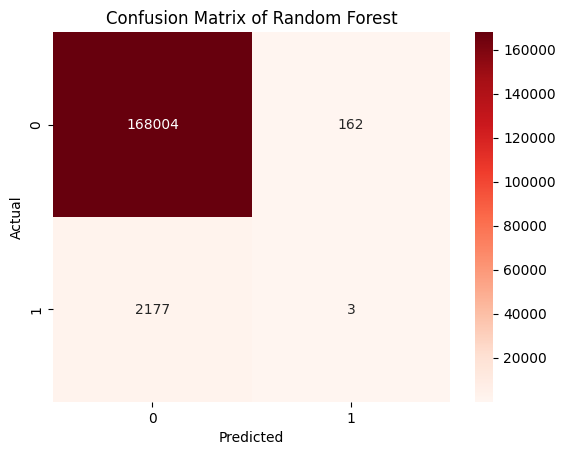

Evaluation results of Random Forest on Unknown saved to ../results/metrics.json


In [38]:
# Predict using the Random Forest model
y_pred_rf = calculate_pred(model_rf, x_test_1, y_test)
# Print evaluation metrics
print_evaluation_metrics(y_test, y_pred_rf, "Random Forest")
# Save evaluation metrics
metrics_rf = evaluate_and_save(model_rf, x_test_1, y_test, y_pred_rf, 'Random Forest', 'Supervised', 'Unknown', "../results/metrics.json")

Evaluation Metrics for Decision Tree
Accuracy: 0.99
Classification Report:
{'0': {'precision': 0.9873614907562531, 'recall': 0.9988047524469869, 'f1-score': 0.9930501565266746, 'support': 168166.0}, '1': {'precision': 0.12987012987012986, 'recall': 0.013761467889908258, 'f1-score': 0.02488593944421402, 'support': 2180.0}, 'accuracy': 0.9861986779848074, 'macro avg': {'precision': 0.5586158103131915, 'recall': 0.5062831101684475, 'f1-score': 0.5089680479854443, 'support': 170346.0}, 'weighted avg': {'precision': 0.9763877598395793, 'recall': 0.9861986779848074, 'f1-score': 0.9806600916396812, 'support': 170346.0}}
Confusion Matrix:


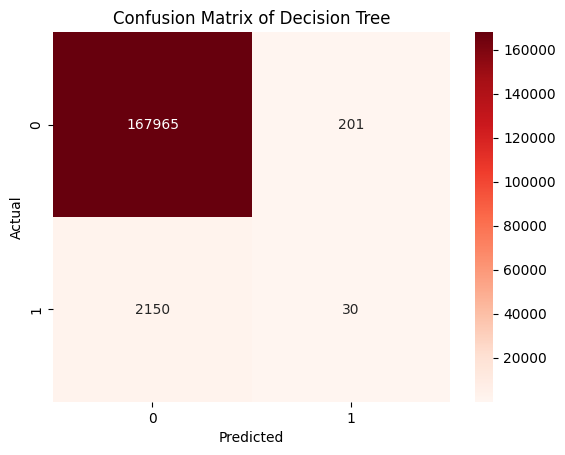

Evaluation results of Decision Tree on Unknown saved to ../results/metrics.json


In [39]:
# Predict using the Decision Tree model
y_pred_dt = calculate_pred(model_dt, x_test_1, y_test)
# Print evaluation metrics
print_evaluation_metrics(y_test, y_pred_dt, "Decision Tree")
# Save evaluation metrics
metrics_dt = evaluate_and_save(model_dt, x_test_1, y_test, y_pred_dt, 'Decision Tree', 'Supervised', 'Unknown', "../results/metrics.json")

Evaluation Metrics for XGBoost
Accuracy: 0.99
Classification Report:
{'0': {'precision': 0.9943381491604841, 'recall': 0.9994231889918295, 'f1-score': 0.996874184440912, 'support': 168166.0}, '1': {'precision': 0.9265151515151515, 'recall': 0.5610091743119267, 'f1-score': 0.6988571428571428, 'support': 2180.0}, 'accuracy': 0.9938125931926785, 'macro avg': {'precision': 0.9604266503378178, 'recall': 0.780216181651878, 'f1-score': 0.8478656636490274, 'support': 170346.0}, 'weighted avg': {'precision': 0.9934701855166839, 'recall': 0.9938125931926785, 'f1-score': 0.9930603164859696, 'support': 170346.0}}
Confusion Matrix:


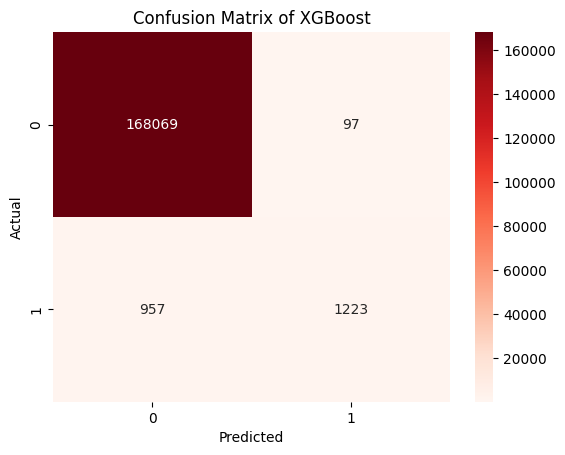

Evaluation results of XGBoost on Unknown saved to ../results/metrics.json


In [40]:
# Predict using the XGBoost model
y_pred_xgb = calculate_pred(model_xgb, x_test_1, y_test)
# Print evaluation metrics
print_evaluation_metrics(y_test, y_pred_xgb, "XGBoost")
# Save evaluation metrics
metrics_xgb = evaluate_and_save(model_xgb, x_test_1, y_test, y_pred_xgb, 'XGBoost', 'Supervised', 'Unknown', "../results/metrics.json")

In [41]:
# Load the scalers of the unsupervised training
x_test_iso = load_scaler_and_transform(x_test, "../models/scalers/2.2_iso_scaler.pkl")
x_test_iso = load_pca_and_transform(x_test_iso, "../models/pca/pca.pkl")

x_test_ae = load_scaler_and_transform(x_test, "../models/scalers/2.2_ae_scaler.pkl")

In [42]:
# Load the Isolation Forest trained model
model_iso = load_saved_object("../models/isolation_forest_model2.pkl")

Evaluation Metrics for Isolation Forest
Accuracy: 0.67
Classification Report:
{'0': {'precision': 0.9984501753515888, 'recall': 0.6704149471355684, 'f1-score': 0.8021929543691877, 'support': 168166.0}, '1': {'precision': 0.034912066864008356, 'recall': 0.9197247706422018, 'f1-score': 0.06727059218251971, 'support': 2180.0}, 'accuracy': 0.6736054853063764, 'macro avg': {'precision': 0.5166811211077985, 'recall': 0.7950698588888852, 'f1-score': 0.4347317732758537, 'support': 170346.0}, 'weighted avg': {'precision': 0.9861193130096322, 'recall': 0.6736054853063763, 'f1-score': 0.7927877981015504, 'support': 170346.0}}
Confusion Matrix:


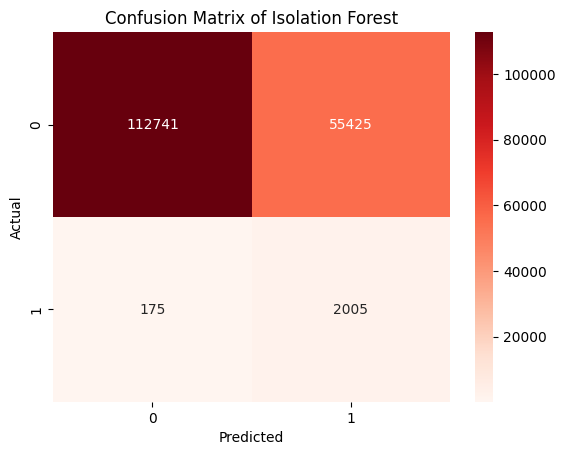

Evaluation results of Isolation Forest on Unknown saved to ../results/metrics.json


In [43]:
# Predict using the Isolation Forest model
y_pred_iso = calculate_pred(model_iso, x_test_iso, y_test, 'iso')
# Print evaluation metrics
print_evaluation_metrics(y_test, y_pred_iso, 'Isolation Forest')
# Save evaluation metrics
metrics_iso = evaluate_and_save(model_iso, x_test_iso, y_test, y_pred_iso, 'Isolation Forest', 'Unsupervised', 'Unknown', "../results/metrics.json")

In [44]:
# Load the Autoencoder trained model
model_ae = load_saved_object("../models/autoencoder_model2.pkl")

 169/5324 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step

5324/5324 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step
Best threshold based on F1: 0.00018310550402831448
Evaluation Metrics for Autoencoder
Accuracy: 0.86
Classification Report:
{'0': {'precision': 0.9981097978937747, 'recall': 0.8572244092147046, 'f1-score': 0.9223180153233417, 'support': 168166.0}, '1': {'precision': 0.07358104718910367, 'recall': 0.8747706422018349, 'f1-score': 0.13574402961170232, 'support': 2180.0}, 'accuracy': 0.8574489568290421, 'macro avg': {'precision': 0.5358454225414392, 'recall': 0.8659975257082697, 'f1-score': 0.529031022467522, 'support': 170346.0}, 'weighted avg': {'precision': 0.9862781571359279, 'recall': 0.8574489568290421, 'f1-score': 0.9122518482935824, 'support': 170346.0}}
Confusion Matrix:


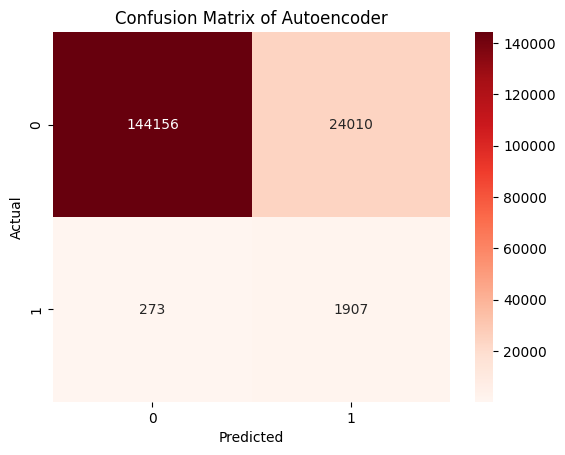

5324/5324 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step
Evaluation results of Autoencoder on Unknown saved to ../results/metrics.json


In [45]:
# Predict using the Autoencoder
y_pred_ae = calculate_pred(model_ae, x_test_ae, y_test, 'ae')
# Print evaluation metrics
print_evaluation_metrics(y_test, y_pred_ae, 'Autoencoder')
# Save evaluation metrics
metrics_ae = evaluate_and_save(model_ae, x_test_ae, y_test, y_pred_ae, 'Autoencoder', 'Unsupervised', 'Unknown', "../results/metrics.json")

1207/5324 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step

5324/5324 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step
Evaluation Metrics for Combined Model (AE + ISO)
Accuracy: 0.02
Classification Report:
{'0': {'precision': 0.9894389438943895, 'recall': 0.008913811353067801, 'f1-score': 0.01766844844148726, 'support': 168166.0}, '1': {'precision': 0.01281755127908974, 'recall': 0.9926605504587156, 'f1-score': 0.02530831350030115, 'support': 2180.0}, 'accuracy': 0.021503293297171638, 'macro avg': {'precision': 0.5011282475867396, 'recall': 0.5007871809058917, 'f1-score': 0.021488380970894207, 'support': 170346.0}, 'weighted avg': {'precision': 0.9769406484492286, 'recall': 0.021503293297171638, 'f1-score': 0.017766219482945315, 'support': 170346.0}}
Confusion Matrix:


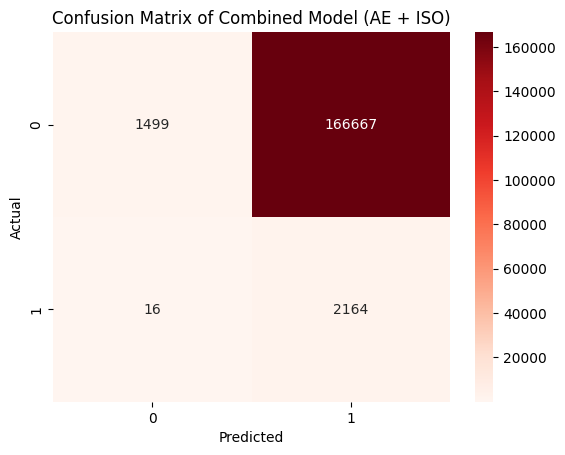

Evaluation results of Combined Model (AE + ISO) on Unknown saved to ../results/metrics.json


In [46]:
# Predict using the Combined Model
threshold = 0.0000056
combined_pred = predict_combined(model_ae, model_iso, threshold, x_test_ae, x_test_iso)
# Print evaluation metrics
print_evaluation_metrics(y_test, combined_pred, 'Combined Model (AE + ISO)')
# Save evaluation metrics
metrics_combined = evaluate_and_save( None, None, y_test, combined_pred, 'Combined Model (AE + ISO)','Unsupervised', 'Unknown', "../results/metrics.json")

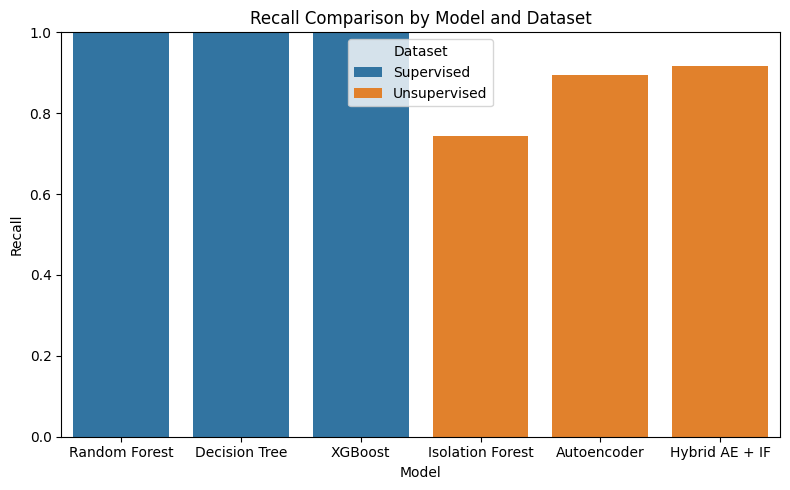

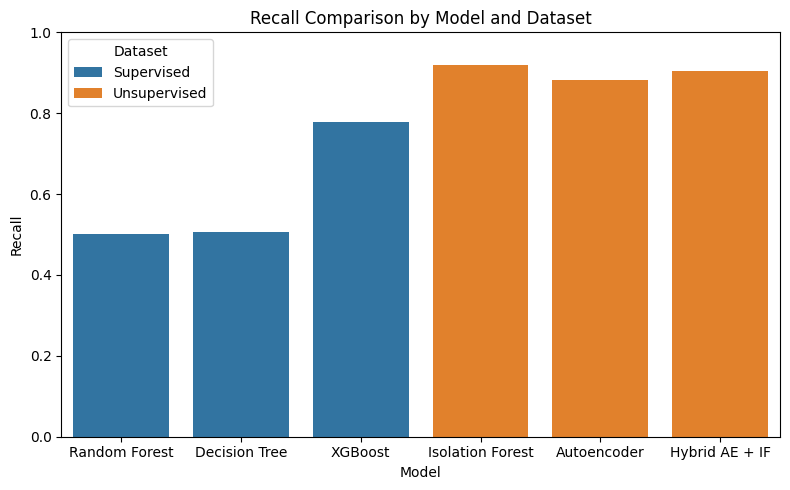

In [47]:
# Plot Recall Comparison

data_known = {
    'Model': ['Random Forest', 'Decision Tree', 'XGBoost', 'Isolation Forest', 'Autoencoder', 'Hybrid AE + IF'],
    'Dataset': ['Supervised', 'Supervised', 'Supervised', 'Unsupervised', 'Unsupervised', 'Unsupervised'],
    'Recall': [0.9989, 0.9988, 0.9996, 0.7442, 0.8950, 0.9167]
}

data_unknown = {
    'Model': ['Random Forest', 'Decision Tree', 'XGBoost', 'Isolation Forest', 'Autoencoder', 'Hybrid AE + IF'],
    'Dataset': ['Supervised', 'Supervised', 'Supervised', 'Unsupervised', 'Unsupervised', 'Unsupervised'],
    'Recall': [0.5009, 0.5071, 0.7783, 0.9195, 0.8823, 0.9048]
}

plot_recall_comparison(data_known)
plot_recall_comparison(data_unknown)

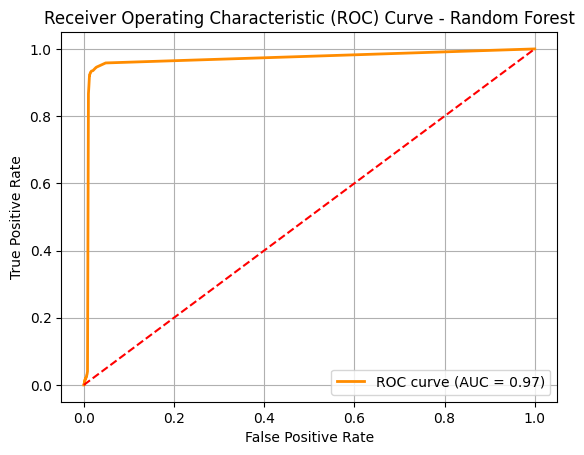

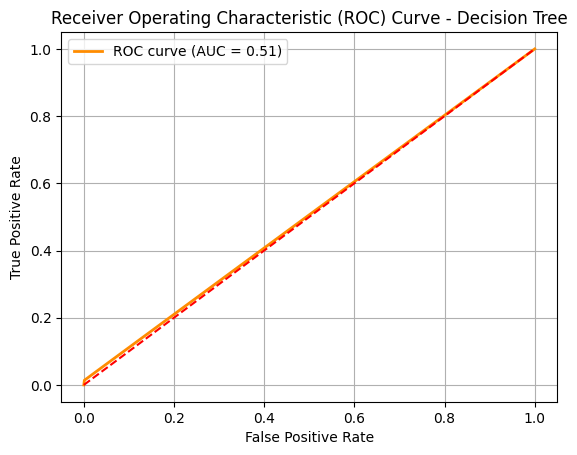

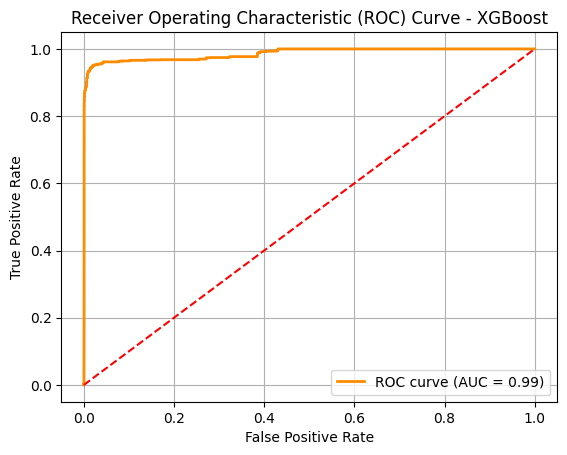

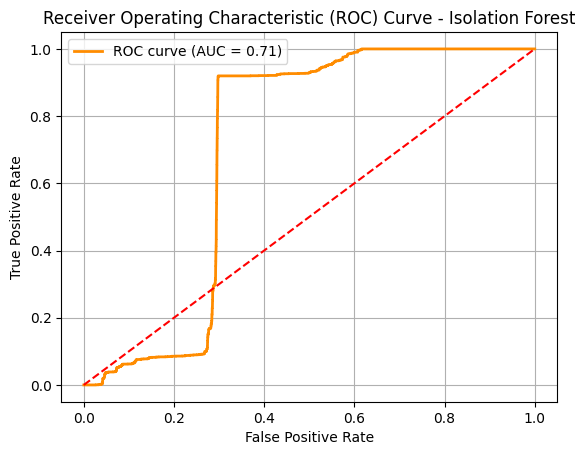

5324/5324 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step


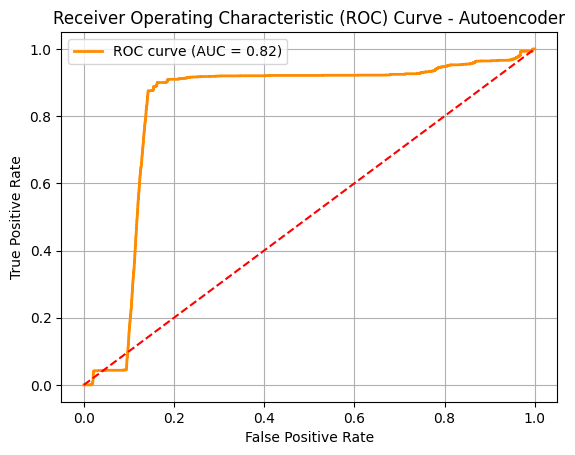

In [48]:
# Plot ROC curves
plot_roc_curve(model_rf, x_test_1, y_test, "Random Forest")
plot_roc_curve(model_dt, x_test_1, y_test, "Decision Tree")
plot_roc_curve(model_xgb, x_test_1, y_test, "XGBoost")
plot_roc_curve(model_iso, x_test_iso, y_test, "Isolation Forest")
plot_roc_curve(model_ae, x_test_ae, y_test, "Autoencoder")